# Intro

# Libraries

In [1]:
import gc
import logging
import os
import shutil

import matplotlib.pyplot as plt
import mlflow as mlf
import pandas as pd
import pingouin as pg
import scipy.stats as st
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as krs
import tensorflow_probability as tfp

import src.algorithms.advantages as adv
import src.algorithms.algo_utils as autil
import src.algorithms.dummy as dummy
import src.algorithms.policy_gradient.tf2.ac as ac
import src.algorithms.policy_gradient.tf2.ppo as ppo
import src.algorithms.policy_gradient.tf2.vpg as vpg
import src.models.base_models.tf2.policy_nets as policy_nets
import src.models.base_models.tf2.value_nets as vnets
import src.utils as util
from src.envs.resource_allocation_env import DiscreteProjectsEnv, DiscreteProjectOptimizerAgent

C:\Users\fwojcik\Anaconda3\envs\py39\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
from importlib import reload

In [3]:
dummy = reload(dummy)

In [2]:
log = logging.getLogger()
log.setLevel(logging.INFO)
std_handler = logging.StreamHandler(sys.stdout)
log.addHandler(std_handler)

In [3]:
mlf.autolog()
mlf.tensorflow.autolog()
mlf.keras.autolog()

2022/03/25 09:17:30 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2022/03/25 09:17:30 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2022/03/25 09:17:30 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2022/03/25 09:17:30 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2022/03/25 09:17:30 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
C:\Users\fwojcik\Anaconda3\envs\py39\lib\site-packages\mlflow\utils\autologging_u

# Easy env

In [4]:
ENV_SIZE = 300

In [9]:
env_easy = DiscreteProjectsEnv(
    start_resource=100,
    start_cash=100,
    upkeep_cost=-1,
    min_payout=-0.5,
    max_payout=1.5,
    payout_mean=1.0,
    payout_std=0.5,
    size=ENV_SIZE,
    distrib_prob=tfp.distributions.TruncatedNormal(0.7, 0.2, 0.0, 1.0),
    balance_is_reward=False,
    stochastic=True)

s_dim = env_easy.observation_space.shape[0]
a_dim = env_easy.action_space.n

<AxesSubplot:>

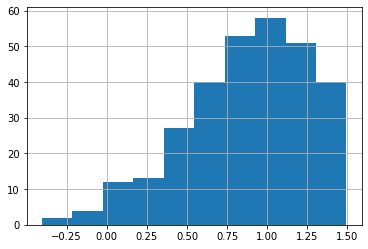

In [10]:
env_easy.projects.proj_1_payouts.hist()

<AxesSubplot:>

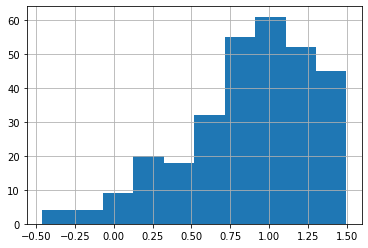

In [11]:
env_easy.projects.proj_2_payouts.hist()

## Agents

#### PPO

In [ ]:
krs.backend.clear_session()
print(gc.collect())

In [32]:
s_dim = env_easy.observation_space.shape[0]
a_dim = env_easy.action_space.n

initializer = krs.initializers.HeNormal()
policy_net_ppo = policy_nets.DiscretePolicyNet(a_dim, [128, 128, 128], 'tanh', hidden_initializer=initializer, out_initializer=initializer)
value_net_ppo = vnets.ValueNet(s_dim, [64, 64], h_act='tanh', out_act='linear', initializer=initializer)

policy_opt = krs.optimizers.Adam(0.0003)
value_opt = krs.optimizers.Adam(0.0003)

agent_ppo = ppo.PPO(
    policy_net_ppo,
    value_net_ppo,
    policy_opt,
    value_opt,
    adv.GAE,
    n_agents=3,
    clipping_eps=0.1,
    entropy_coef=0.001)

#### AC

In [13]:
policy_net_ac = policy_nets.DiscretePolicyNet(a_dim, [128, 128], 'tanh', hidden_initializer=initializer, out_initializer=initializer)
value_net_ac = vnets.ValueNet(s_dim, [64, 64], h_act='tanh', out_act='linear', initializer=initializer)

agent_ac = ac.ActorCrtic(
    policy_net_ac,
    value_net_ac,
    krs.optimizers.Adam(0.0005), #, clipnorm=1.),
    krs.optimizers.Adam(0.0003), #, clipnorm=1.),
    adv.GAE,
    entropy_coef=0.001)

#### VPG

In [14]:
policy_net_vpg = policy_nets.DiscretePolicyNet(a_dim, [128, 128], 'tanh', hidden_initializer=initializer, out_initializer=initializer)
value_net_vpg = vnets.ValueNet(s_dim, [64, 64], h_act='tanh', out_act='linear', initializer=initializer)

agent_vpg = vpg.VPG(
    policy_net_vpg,
    value_net_vpg,
    adv.GAE,
    policy_opt=krs.optimizers.Adam(0.0005), #, clipnorm=1.),
    value_opt=krs.optimizers.Adam(0.0003), #, clipnorm=1.),
    entropy_coef=0.001)

In [15]:
dummy_agent = DiscreteProjectOptimizerAgent(env_easy)

In [16]:
random_agent = dummy.DummyAgent(env_easy)

## Evaluate before training

In [17]:
ppo_scores_before = autil.evaluate_algorithm(agent_ppo, env_easy, n_episodes=500, max_ep_steps=ENV_SIZE, clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [18]:
ac_scores_before = autil.evaluate_algorithm(agent_ac, env_easy, n_episodes=500, max_ep_steps=ENV_SIZE, clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [19]:
vpg_scores_before = autil.evaluate_algorithm(agent_vpg, env_easy, n_episodes=500, max_ep_steps=ENV_SIZE, clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [20]:
dummy_scores = autil.evaluate_algorithm(dummy_agent, env_easy, n_episodes=500, max_ep_steps=ENV_SIZE, clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [21]:
random_scores = autil.evaluate_algorithm(random_agent, env_easy, n_episodes=500, max_ep_steps=ENV_SIZE, clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

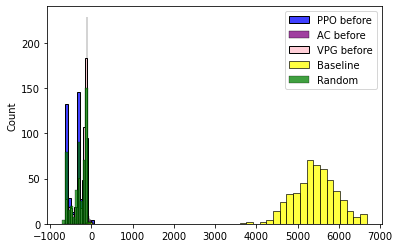

In [22]:
sns.histplot(ppo_scores_before, color='blue', label='PPO before')
sns.histplot(ac_scores_before, color='purple', label='AC before')
sns.histplot(vpg_scores_before, color='pink', label='VPG before')
sns.histplot(dummy_scores, color='yellow', label='Baseline')
sns.histplot(random_scores, color='green', label='Random')
plt.legend()

## Train agent

In [23]:
EXPERIMENT_EASY = 'projects_env_easy'

In [24]:
experiment_id_easy = util.prepare_mlflow(EXPERIMENT_EASY)

#### Train PPO

In [33]:
env_easy.reset()
with mlf.start_run(experiment_id=experiment_id_easy, run_name='PPO easy'):
    ppo_scores_after = agent_ppo.train(env_easy, 600, max_steps=ENV_SIZE, average_n_last=30, print_interval=10, epochs=5, batch_size=64, log=log, gamma=0.99, clip_action=False, max_train_sec=30 * 60)

Ep: 0/200  Rewards avg.: -333.333  Loss avg.: nan  Time passed: 0.000/30.000
Ep: 10/200  Rewards avg.: -224.353  Loss avg.: 0.799  Time passed: 0.084/30.000
Ep: 20/200  Rewards avg.: -68.304  Loss avg.: 0.813  Time passed: 0.280/30.000
Ep: 30/200  Rewards avg.: 446.267  Loss avg.: 0.930  Time passed: 1.118/30.000
Ep: 40/200  Rewards avg.: 1443.155  Loss avg.: 1.006  Time passed: 2.163/30.000
Ep: 50/200  Rewards avg.: 2431.326  Loss avg.: 1.113  Time passed: 3.252/30.000
Ep: 60/200  Rewards avg.: 3179.064  Loss avg.: 1.122  Time passed: 4.272/30.000
Ep: 70/200  Rewards avg.: 3625.451  Loss avg.: 1.242  Time passed: 5.280/30.000
Ep: 80/200  Rewards avg.: 4066.674  Loss avg.: 1.732  Time passed: 6.292/30.000
Ep: 90/200  Rewards avg.: 4286.258  Loss avg.: 1.186  Time passed: 7.297/30.000
Ep: 100/200  Rewards avg.: 4498.987  Loss avg.: 2.271  Time passed: 8.248/30.000
Ep: 110/200  Rewards avg.: 4615.232  Loss avg.: 2.601  Time passed: 9.199/30.000
Ep: 120/200  Rewards avg.: 4912.110  Loss a

#### Train AC

In [26]:
env_easy.reset()
with mlf.start_run(experiment_id=experiment_id_easy, run_name='AC easy'):
    ac_scores_after = agent_ac.train(
        env_easy,
        500,
        max_steps=ENV_SIZE,
        average_n_last=30,
        print_interval=10,
        log=log,
        gamma=0.99,
        clip_action=False,
        max_train_sec=15*60,
        n_steps=25)

Ep: 0/500  Rewards avg.: -94.075  Loss avg.: 0.869  Time passed: 0.003/15.000
Ep: 10/500  Rewards avg.: -137.703  Loss avg.: 0.571  Time passed: 0.009/15.000
Ep: 20/500  Rewards avg.: -150.810  Loss avg.: 0.553  Time passed: 0.013/15.000
Ep: 30/500  Rewards avg.: -159.494  Loss avg.: 0.437  Time passed: 0.017/15.000
Ep: 40/500  Rewards avg.: -180.872  Loss avg.: 0.250  Time passed: 0.022/15.000
Ep: 50/500  Rewards avg.: -159.130  Loss avg.: 0.180  Time passed: 0.027/15.000
Ep: 60/500  Rewards avg.: -135.400  Loss avg.: 0.101  Time passed: 0.032/15.000
Ep: 70/500  Rewards avg.: -100.000  Loss avg.: 0.108  Time passed: 0.037/15.000
Ep: 80/500  Rewards avg.: -100.067  Loss avg.: 0.068  Time passed: 0.041/15.000
Ep: 90/500  Rewards avg.: -113.467  Loss avg.: 0.099  Time passed: 0.045/15.000
Ep: 100/500  Rewards avg.: -113.774  Loss avg.: 0.188  Time passed: 0.052/15.000
Ep: 110/500  Rewards avg.: -147.632  Loss avg.: 0.141  Time passed: 0.058/15.000
Ep: 120/500  Rewards avg.: 145.414  Loss

#### Train VPG

In [27]:
env_easy.reset()
with mlf.start_run(experiment_id=experiment_id_easy, run_name='VPG easy'):
    vpg_scores_after = agent_vpg.train(
        env_easy,
        500,
        max_steps=ENV_SIZE,
        average_n_last=30,
        print_interval=10,
        log=log,
        gamma=0.99,
        clip_action=False,
        max_train_sec=15*60)

Ep: 0/500  Rewards avg.: nan  Loss avg.: 0.067  Time passed: 0.001/15.000


C:\Users\fwojcik\Anaconda3\envs\py39\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\fwojcik\Anaconda3\envs\py39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ep: 10/500  Rewards avg.: -221.354  Loss avg.: 0.456  Time passed: 0.009/15.000
Ep: 20/500  Rewards avg.: -17.992  Loss avg.: 0.534  Time passed: 0.090/15.000
Ep: 30/500  Rewards avg.: 1073.358  Loss avg.: 0.645  Time passed: 0.423/15.000
Ep: 40/500  Rewards avg.: 2277.771  Loss avg.: 0.775  Time passed: 0.667/15.000
Ep: 50/500  Rewards avg.: 3721.396  Loss avg.: 0.895  Time passed: 0.978/15.000
Ep: 60/500  Rewards avg.: 4112.932  Loss avg.: 0.947  Time passed: 1.272/15.000
Ep: 70/500  Rewards avg.: 4611.590  Loss avg.: 0.981  Time passed: 1.584/15.000
Ep: 80/500  Rewards avg.: 4694.877  Loss avg.: 0.984  Time passed: 1.895/15.000
Ep: 90/500  Rewards avg.: 4716.531  Loss avg.: 0.982  Time passed: 2.193/15.000
Ep: 100/500  Rewards avg.: 4717.881  Loss avg.: 0.983  Time passed: 2.496/15.000
Ep: 110/500  Rewards avg.: 4747.806  Loss avg.: 0.988  Time passed: 2.798/15.000
Ep: 120/500  Rewards avg.: 4787.446  Loss avg.: 0.997  Time passed: 3.101/15.000
Ep: 130/500  Rewards avg.: 4718.783  L

## Eval after train

In [28]:
results_dir = "discrete_env_results_easy"

In [54]:
if os.path.exists(results_dir):
    shutil.rmtree(results_dir)
    os.mkdir(results_dir)

## Compare results

In [ ]:
ppo_eval_scores_after = autil.evaluate_algorithm(agent_ppo, env_easy, n_episodes=500, max_ep_steps=ENV_SIZE,
                                                 clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [31]:
ac_eval_scores_after_500 =  autil.evaluate_algorithm(agent_ac, env_easy, n_episodes=500, max_ep_steps=ENV_SIZE,
                                                     clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [30]:
vpg_eval_scores_after_500 =  autil.evaluate_algorithm(agent_vpg, env_easy, n_episodes=500, max_ep_steps=ENV_SIZE,
                                                      clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [39]:
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

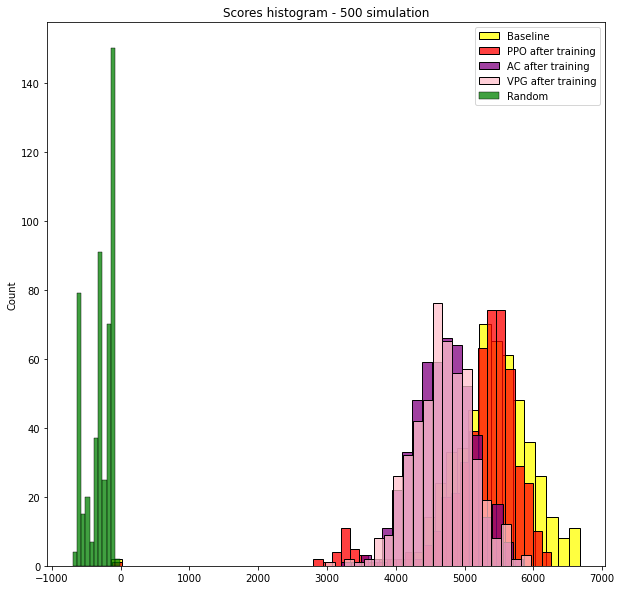

In [40]:
plt.figure(figsize=(10, 10))
sns.histplot(dummy_scores, color='yellow', label='Baseline')
sns.histplot(ppo_eval_scores_after, color='red', label='PPO after training')
sns.histplot(ac_eval_scores_after_500, color='purple', label='AC after training')
sns.histplot(vpg_eval_scores_after_500, color='pink', label='VPG after training')
sns.histplot(random_scores, color='green', label='Random')
plt.title("Scores histogram - 500 simulation")
plt.legend()
plt.savefig(f"./{results_dir}/scores_histogram.png")

In [61]:
result_df = pd.DataFrame({
  #  'PPO before': ppo_scores_before,
  #  'AC before': ac_scores_before,
  #  'VPG before': vpg_scores_before,
    'random': random_scores,
    'PPO after': ppo_eval_scores_after,
    'AC after': ac_eval_scores_after_500,
    'VPG after': vpg_eval_scores_after_500,
    'baseline': dummy_scores, })
result_df.describe()

,random,PPO after,AC after,VPG after,baseline
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-290.890025,5221.024898,4685.794335,4681.177518,5400.996065
std,181.360463,653.343127,425.213991,437.656198,619.268838
min,-699.896106,-120.369021,3206.577595,2968.779187,-138.049659
25%,-386.495477,5055.285679,4384.385283,4399.867005,5087.344018
50%,-270.730687,5367.668251,4690.118648,4680.816353,5423.374808
75%,-130.682287,5593.634873,4981.056562,4973.264747,5745.647612
max,-17.056267,6258.740863,5845.886901,5961.670288,6676.670291


In [48]:
result_df.to_csv(os.path.join(results_dir, "scores_easy_env.csv"), index=False)

In [49]:
stat, pval = st.levene(*[result_df[c] for c in result_df.columns])
pval.round(4)

0.0

In [62]:
melted_df = result_df.melt(var_name='model')
result = pg.welch_anova(melted_df, dv='value', between='model')
result.round(2)

,Source,ddof1,ddof2,F,p-unc,np2
0,model,4,1151.15,34759.39,0.0,0.95


In [51]:
pairwise_test = pg.pairwise_gameshowell(melted_df, dv='value', between='model', effsize='cohen')
pairwise_test

,A,B,mean(A),mean(B),diff,se,T,df,pval,cohen
0,AC after,PPO after,4685.794335,5221.024898,-535.230564,34.861560,-15.353030,857.422612,0.001,-0.971011
1,AC after,VPG after,4685.794335,4681.177518,4.616817,27.289188,0.169181,997.171003,0.900,0.010700
2,AC after,baseline,4685.794335,5400.996065,-715.201730,33.594667,-21.289145,883.958692,0.001,-1.346444
3,AC after,random,4685.794335,-290.890025,4976.684359,20.673585,240.726724,674.736160,0.001,15.224895
4,PPO after,VPG after,5221.024898,4681.177518,539.847380,35.168173,15.350453,871.770831,0.001,0.970848
5,PPO after,baseline,5221.024898,5400.996065,-179.971166,40.257947,-4.470451,995.150374,0.001,-0.282736
6,PPO after,random,5221.024898,-290.890025,5511.914923,30.323221,181.772080,575.447293,0.001,11.496276
7,VPG after,baseline,4681.177518,5400.996065,-719.818547,33.912736,-21.225611,897.944977,0.001,-1.342426
8,VPG after,random,4681.177518,-290.890025,4972.067543,21.186532,234.680578,665.467143,0.001,14.842503
9,baseline,random,5400.996065,-290.890025,5691.886089,28.857772,197.239275,583.971690,0.001,12.474507


In [52]:
pairwise_test.to_csv(os.path.join(results_dir, "pairwise_test_res_easy_env.csv"), index=False)